In [102]:
import pandas as pd
import numpy as np
pd.options.mode.copy_on_write = True
import datetime
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [104]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

# The Advanced Computing Center for Research and Education


Project Overview The Advanced Computing Center for Research and Education (ACCRE) operates Vanderbilt University's high-performance computing cluster. Jobs submitted to ACCRE are managed by the slurm scheduler, which tracks compute and memory resources.

ACCRE staff have hypothesized that the scheduler sometimes becomes unresponsive because it is processing large bursts of job completions. This especially affects automated job submitters, such as members of the Open Science Grid.

**Your goal is to evaluate whether the data supports the hypothesis of bursts of job completions contributing to scheduler unresponsiveness.** <br>
**(The big question: how many jobs can ACCRE process in an hour before 
issues emerge)** <br>
**(Answer the main question: Does the data support the hypothesis that the slurm scheduler is more likely to be unresponsive during bursts of job completions?)**
**Optionally include other features (currently running jobs or resource usage, time-of-day).**


You are provided three datasets:

fullsample.csv: Contains slurm job records. Job completions correspond to jobs in the "COMPLETED" state with exit code "0:0".
slurm_wrapper_ce5.log, slurm_wrapper_ce6.log: These log files contain every slurm command executed by the CE5 and CE6 servers (gateways to the Open Science Grid).
Unresponsive periods are indicated by "sbatch" commands from user 9204 that have:
return code = 1
execution time > 15 seconds

## 1. Introduction & dataset overview  

I have loaded the slurm datasets and saved the unresponsive period data to csv files

## Phase 1: Explore the Data<br>

#### Objectives:

Understand the purpose of each dataset.<br>
Inspect column types, sizes, and example rows. 
<br>
<br>
#### Notebook Sections:

Code: Load each dataset, preview rows, summarize columns.
<br>
Markdown: Notes on data quality and initial observations.

The entire fullsample csv file contains 7,395,885 rows of data, one row per job. 

In [8]:
def completed_jobs(filehere):
    
    ## read the jobs data into the notebook
    chunk = pd.read_csv(f'../data/{filehere}', chunksize=100000)#, nrows=100000) 

    ## initialize empty DataFrame: data
    data = pd.DataFrame()

    ## iterate over each DataFrame chunk
    for portion in chunk:
        ## replace the unknowns in jobs df with nan values
        ## assign it to a new df, chunk_replace_unknown
        chunk_replace_unknown = portion.replace("Unknown", np.nan)

        ## isolate the rows containing exitcode 0:0
        exit = chunk_replace_unknown[chunk_replace_unknown['EXITCODE'].str[-3:] == '0:0']

        ## further isolate rows in df to capture only COMPLETED STATE rows
        completed_exit = exit[exit['STATE'] == 'COMPLETED']

        ## convert the BEGIN column to datetime from the format it was originally presented in
        ## assign it back to that column of the completed_exit
        completed_exit['BEGIN'] = pd.to_datetime(completed_exit['BEGIN'], format = "%Y-%m-%dT%H:%M:%S")
    
        ## convert the END column to datetime from the format it was originally presented in
        ## assign it back to that column of the completed_exit
        completed_exit['END'] = pd.to_datetime(completed_exit['END'], format = "%Y-%m-%dT%H:%M:%S")
    
        ## Concatenate DataFrame chunk to the end of data: data
        data = pd.concat([data, completed_exit])
    data.to_csv('../data/completed_jobs.csv')
    
    return data 

In [9]:
filehere = 'fullsample.csv'

In [10]:
#completed_jobs_df = completed_jobs(filehere)#.head(2)
completed_jobs_df = pd.read_csv("../data/completed_jobs.csv")
completed_jobs_df.head(2)

,Unnamed: 0,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
0,1,30853133,COMPLETED,2021-08-06 11:36:09,2021-09-05 11:36:32,262144Mn,20604.62M,30-00:00:00,30-00:00:23,1,1,cgw-platypus,0:0
1,2,30858137,COMPLETED,2021-08-06 19:04:39,2021-09-05 19:04:53,204800Mn,57553.77M,30-00:00:00,30-00:00:14,1,32,cgw-tbi01,0:0


In [11]:
completed_jobs_df.rename(
    columns={"Unnamed: 0": "unnamed_id"}
).head(2)

,unnamed_id,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
0,1,30853133,COMPLETED,2021-08-06 11:36:09,2021-09-05 11:36:32,262144Mn,20604.62M,30-00:00:00,30-00:00:23,1,1,cgw-platypus,0:0
1,2,30858137,COMPLETED,2021-08-06 19:04:39,2021-09-05 19:04:53,204800Mn,57553.77M,30-00:00:00,30-00:00:14,1,32,cgw-tbi01,0:0


## Slurm Wrapper ce5 & ce6

In [13]:
def build_slurm(filename):
    
    ## read the first of two log files, ce5, into the notebook in chunks
    chunk = pd.read_csv(f'../data/{filename}',
                  header=None,
                  delimiter=' - ',
                  engine='python',
                  chunksize=100000)

    ## initialize empty DataFrame: data
    data = pd.DataFrame()

    ## iterate over each DataFrame chunk
    for portion in chunk:
        ## rename the columns to words instead of simply numbers
        named = portion.rename(columns={0: 'date_time', 1: 'user', 2: 'retry', 3: 'time', 4: 'returncode', 5: 'command'})

        ## convert the date_time column to datetime from the format it was originally presented in
        ## assign it back to that column of the ce5_names df
        named['date_time'] = pd.to_datetime(named['date_time'], format = "mixed")

        ## strip the word user from within the user column and we are left with a number
        named["user"] = named["user"].str.strip("user")
        named["user"] = pd.to_numeric(named["user"])

        ## strip the word retry from within the retry column and we are left with a number
        named["retry"] = named["retry"].str.strip("retry")
        named["retry"] = pd.to_numeric(named["retry"])

        ## strip the word time from within the time column and we are left with a number
        named["time"] = named["time"].str.strip("time")
        named["time"] = pd.to_numeric(named["time"])
    
        ## strip the word returncode from within the returncode column and we are left with a number
        named["returncode"] = named["returncode"].str.strip("returncode")
        named["returncode"] = pd.to_numeric(named["returncode"])

        ## strip the word command from within the command column
        named["command"] = named["command"].str.strip("command")

        ## locate rows which contain sbatch 
        named["sbatch"] = named["command"].str.contains("/usr/bin/sbatch")
        ## save rows where the command column contains sbatch to a new df, named_sbatch
        named_sbatch = named[named["sbatch"] == True]

        ## locate and save rows where the user column contains 9204 to a new df, named_sbatch_user
        named_sbatch_user = named_sbatch[named_sbatch["user"] == 9204]

        ## locate and save rows where the returncode column contains 1 to a new df, named_sbatch_user_returncode
        ## locate and save rows where the returncode column contains 1 to a new df, unresponsive_periods
        named_sbatch_user["is_unresponsive"] = (named_sbatch_user["returncode"] == 1) & (named_sbatch_user["time"] > 15)

        # Concatenate DataFrame chunk to the end of data: data
        data = pd.concat([data, named_sbatch_user])
    data.to_csv('../data/ce6_slurm_isresponsive.csv')#('../data/ce5_slurm_unresponsive_periods.csv')
    
    return data

In [14]:
#slurm_isresponsive_5 #slurm_isresponsive_6 = build_slurm(filename)

In [15]:
slurm_isresponsive_6 = pd.read_csv("../data/ce6_slurm_isresponsive.csv")
slurm_isresponsive_6.head(2)

,Unnamed: 0,date_time,user,retry,time,returncode,command,sbatch,is_unresponsive
0,13,2020-10-16 10:38:29.869156,9204,0,0.069466,0,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x...",True,False
1,307,2020-10-16 11:08:28.127242,9204,0,2.433063,0,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x...",True,False


In [16]:
slurm_isresponsive_5 = pd.read_csv("../data/ce5_slurm_isresponsive.csv")
slurm_isresponsive_5.head(2)

,Unnamed: 0,date_time,user,retry,time,returncode,command,sbatch,is_unresponsive
0,136,2020-10-16 08:34:42.779719,9204,0,5.240251,0,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x...",True,False
1,478,2020-10-16 08:53:15.711346,9204,0,0.142444,0,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x...",True,False


The fullsample dataset contains job records, with one row per job.

Each job gets a unique ID, contained in the **JOBID** column.

Some jobs can be submitted as arrays of similar jobs. These are listed with an underscore in the JOBID, where the number after the underscore indicates the tasknumber. For example. JOBID 31781951 was an array job with 10 parts.

Jobs can have a few differents states, with the most common one being 'COMPLETED'. 

The BEGIN field indicates when the job was started (initiated on a computer node).

The END field indicates when the job ended (completed, failed, or was cancelled while running).

The REQMEM field is the amount of memory requested in megabytes. It can be per-core/CPU (Mc) or per-node (Mn).

##### Curious about the range of the dataset. Making sure that the date ranges match with the date ranges

In [20]:
## check beginning date of dataset
completed_jobs_df["BEGIN"].min()

'2020-10-01 00:03:08'

In [21]:
## check ending date of dataset
completed_jobs_df["BEGIN"].max()

'2021-10-07 20:39:26'

In [22]:
## check end date of dataset
slurm_isresponsive_5["date_time"].max()

'2021-10-07 21:53:47.800229'

In [23]:
## check beginning date of dataset
slurm_isresponsive_5["date_time"].min()

'2020-10-16 08:34:42.779719'

In [24]:
## check end date of dataset
slurm_isresponsive_6["date_time"].max()

'2021-10-07 22:00:20.919558'

In [25]:
## check beginning date of dataset
slurm_isresponsive_6["date_time"].min()

'2020-10-16 10:38:29.869156'

In [26]:
## sort keys for concat
slurm_isresponsive_5 = slurm_isresponsive_5.sort_values(by="Unnamed: 0")
slurm_isresponsive_6 = slurm_isresponsive_6.sort_values(by="Unnamed: 0")

In [27]:
## concat the two log files together and rename the index column
slurm_isresponsive_concat = pd.concat(
    [slurm_isresponsive_5, slurm_isresponsive_6], 
    ignore_index=True
).rename(
    columns={"Unnamed: 0": "slurm_id"}
)

In [28]:
## inspect the new slurm df
slurm_isresponsive_concat.head(2)

,slurm_id,date_time,user,retry,time,returncode,command,sbatch,is_unresponsive
0,136,2020-10-16 08:34:42.779719,9204,0,5.240251,0,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x...",True,False
1,478,2020-10-16 08:53:15.711346,9204,0,0.142444,0,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x...",True,False


In [29]:
## convert the date_time column to datetime type
slurm_isresponsive_concat["date_time"] = pd.to_datetime(slurm_isresponsive_concat["date_time"])#.dt.floor('s')

In [30]:
## sort the date_time column of the slurm df
slurm_isresponsive_concat = slurm_isresponsive_concat.sort_values("date_time")#.head(2)
slurm_isresponsive_concat.head(2)

,slurm_id,date_time,user,retry,time,returncode,command,sbatch,is_unresponsive
0,136,2020-10-16 08:34:42.779719,9204,0,5.240251,0,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x...",True,False
1,478,2020-10-16 08:53:15.711346,9204,0,0.142444,0,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x...",True,False


In [31]:
slurm_isresponsive_concat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61247 entries, 0 to 61246
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   slurm_id         61247 non-null  int64         
 1   date_time        61247 non-null  datetime64[ns]
 2   user             61247 non-null  int64         
 3   retry            61247 non-null  int64         
 4   time             61247 non-null  float64       
 5   returncode       61247 non-null  int64         
 6   command          61247 non-null  object        
 7   sbatch           61247 non-null  bool          
 8   is_unresponsive  61247 non-null  bool          
dtypes: bool(2), datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 3.9+ MB


In [32]:
completed_jobs_df = completed_jobs_df.sort_values("END")#.head(2)
completed_jobs_df["END"] = pd.to_datetime(completed_jobs_df["END"])
completed_jobs_df["BEGIN"] = pd.to_datetime(completed_jobs_df["BEGIN"])
completed_jobs_df.head(2)

,Unnamed: 0,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
6620848,6640577,24460577,COMPLETED,2020-10-01 00:05:55,2020-10-01 00:10:15,4096Mc,868.77M,12:00:00,00:04:20,1,1,production,0:0
6620906,6640635,24460647,COMPLETED,2020-10-01 00:10:38,2020-10-01 00:12:58,2000Mn,0.09M,2-00:00:00,00:02:20,1,1,sam,0:0


In [33]:
completed_jobs_df.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 7375084 entries, 6620848 to 1486118
Data columns (total 13 columns):
 #   Column      Dtype         
---  ------      -----         
 0   Unnamed: 0  int64         
 1   JOBID       object        
 2   STATE       object        
 3   BEGIN       datetime64[ns]
 4   END         datetime64[ns]
 5   REQMEM      object        
 6   USEDMEM     object        
 7   REQTIME     object        
 8   USEDTIME    object        
 9   NODES       int64         
 10  CPUS        int64         
 11  PARTITION   object        
 12  EXITCODE    object        
dtypes: datetime64[ns](2), int64(3), object(8)
memory usage: 787.7+ MB


The USEDMEM column is the amount of memory used in MB per node.

The requested time (REQTIME) and used time (USEDTIME) columns are in d-hh:mm:ss or hh:mm:ss for jobs less than one day in duration.

NODES is the number of servers used for the job. Most jobs are single node. For multiple node jobs, memory usage is the maximum over all no
es.
 
CPUS is the total number of CPU cores allocated to the job, and for multi-node jobs, this includes all nodes.

Most jobs are run in the "production" or "nogpfs" partition. The "debug" and "sam" partitions are test jobs that are expected to be short, and the "maxwell", "pascal", and "turing" partitions are for GPU resources.

The **EXITCODE** gives the [exit code](https://www.agileconnection.com/article/overview-linux-exit-codes) for the job, with "0:0" indicating a successful job. Exit codes have two numbers, where if the first number is non-zero, it indicates a problem on the server side and if the second is nonzero, it indicates a problem on the user side.

The slurm_wrapper_ce5.log and slurm_wrapper_ce6.log files contain logs of jobs submitted from the Open Science Grid.

For this project, we are interested in jobs from user 9204 (the test user) where the command starts with '/usr/bin/sbatch, the returncode is non-zero and the time is greater than 15. These conditions indicate that the scheduler became unresponsive at that point in time.

#### Calculated rolling count of jobs completed in 6 minutes, 1 hour, and 1 day

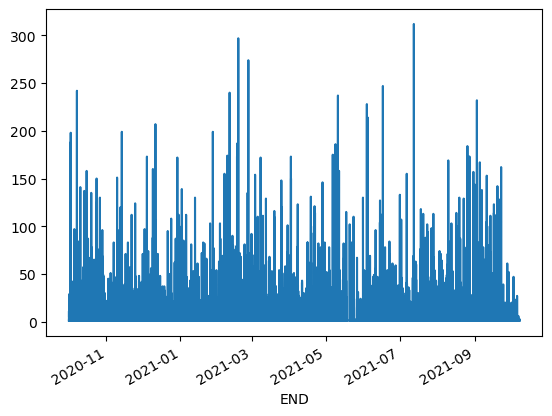

In [39]:
completed_jobs_df.groupby("END").size().plot();

In [40]:
completed_jobs_df["count_of_jobs"] = np.arange(1, len(completed_jobs_df)+1)
completed_jobs_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7375084 entries, 6620848 to 1486118
Data columns (total 14 columns):
 #   Column         Dtype         
---  ------         -----         
 0   Unnamed: 0     int64         
 1   JOBID          object        
 2   STATE          object        
 3   BEGIN          datetime64[ns]
 4   END            datetime64[ns]
 5   REQMEM         object        
 6   USEDMEM        object        
 7   REQTIME        object        
 8   USEDTIME       object        
 9   NODES          int64         
 10  CPUS           int64         
 11  PARTITION      object        
 12  EXITCODE       object        
 13  count_of_jobs  int32         
dtypes: datetime64[ns](2), int32(1), int64(3), object(8)
memory usage: 815.9+ MB


In [41]:
completed_jobs_df['minute'] = completed_jobs_df['END'].dt.minute

In [42]:
completed_jobs_df["rolling_6min"] = completed_jobs_df.rolling(window = "6min", on="END")["count_of_jobs"].count()

In [43]:
completed_jobs_df["rolling_1D"] = completed_jobs_df.rolling(window = "1D", on="END")["count_of_jobs"].count()

In [44]:
completed_jobs_df["rolling_1hour"] = completed_jobs_df.rolling(window = "1h", on="END")["count_of_jobs"].count()

In [45]:
completed_jobs_df.head(2)

,Unnamed: 0,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,count_of_jobs,minute,rolling_6min,rolling_1D,rolling_1hour
6620848,6640577,24460577,COMPLETED,2020-10-01 00:05:55,2020-10-01 00:10:15,4096Mc,868.77M,12:00:00,00:04:20,1,1,production,0:0,1,10,1.0,1.0,1.0
6620906,6640635,24460647,COMPLETED,2020-10-01 00:10:38,2020-10-01 00:12:58,2000Mn,0.09M,2-00:00:00,00:02:20,1,1,sam,0:0,2,12,2.0,2.0,2.0


In [46]:
#ax = completed_jobs_df.plot(x="END", y="rolling_6min", label= "Rolling Average 6 Minutes", color="red", alpha=0.5)
#completed_jobs_df.plot(x="END", y="rolling_1hour", label= "Rolling Average 1 Hour", color="green", ax=ax, alpha=0.5)
#completed_jobs_df.plot(x="END", y="rolling_1D", label= "Rolling Average 1 Day", color="orange", ax=ax, alpha=0.5);

In [47]:
#If I did this correctly, the rolling counts of completed jobs per 1 hour period appears to be a more

Total number of cores or nodes freed up in the last 6 minutes:


## Merge_asof between completed_jobs_df and slurm_isresponsive_concat

In [50]:
completed_jobs_df.head(2)

,Unnamed: 0,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,count_of_jobs,minute,rolling_6min,rolling_1D,rolling_1hour
6620848,6640577,24460577,COMPLETED,2020-10-01 00:05:55,2020-10-01 00:10:15,4096Mc,868.77M,12:00:00,00:04:20,1,1,production,0:0,1,10,1.0,1.0,1.0
6620906,6640635,24460647,COMPLETED,2020-10-01 00:10:38,2020-10-01 00:12:58,2000Mn,0.09M,2-00:00:00,00:02:20,1,1,sam,0:0,2,12,2.0,2.0,2.0


In [ ]:
slurm_isresponsive_concat#.head(2)

In [ ]:
## merge_asof the two log files' concat df with the completed_jobs_df
accre_jobs_and_slurm_log = pd.merge_asof(
    slurm_isresponsive_concat, 
    completed_jobs_df, 
    left_on="date_time", 
    right_on="END",
    allow_exact_matches=False,
    direction="backward"
).rename(
    columns={"Unnamed: 0": "unnamed_job_id"}
)
accre_jobs_and_slurm_log.head(2)

In [53]:
accre_jobs_and_slurm_log["END"].sort_values()

0       2020-10-16 08:34:42
1       2020-10-16 08:53:13
2       2020-10-16 09:04:56
3       2020-10-16 09:24:24
4       2020-10-16 09:34:20
                ...        
61238   2021-10-07 20:41:11
61237   2021-10-07 20:41:11
61236   2021-10-07 20:41:11
61240   2021-10-07 20:41:11
61246   2021-10-07 20:41:11
Name: END, Length: 61247, dtype: datetime64[ns]

## Visualize data

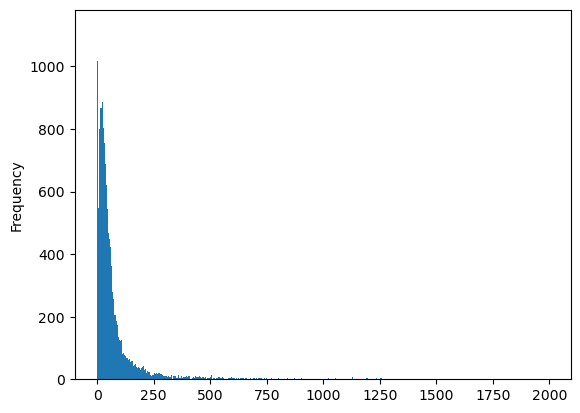

In [144]:
accre_jobs_and_slurm_log['rolling_6min'].plot(kind='hist', bins = 2000);

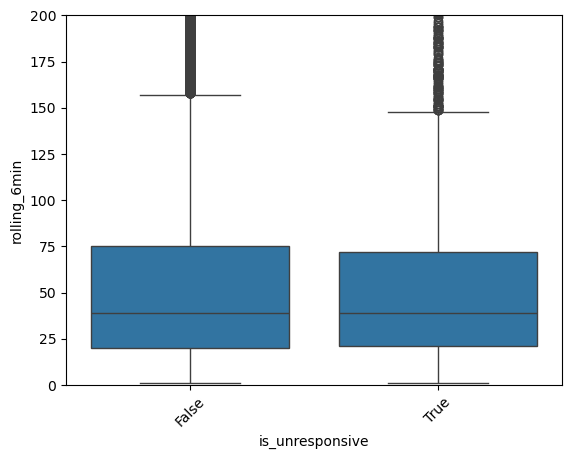

In [74]:
fig, ax = plt.subplots()
sns.boxplot(data=accre_jobs_and_slurm_log, x='is_unresponsive', y='rolling_6min', ax=ax)
#sns.lineplot(data=estimate, x='rolling_6min', y='is_unresponsive', color='purple', ax=ax)
plt.ylim(0, 200)
plt.xticks(rotation=45);
#ax.xaxis.set_major_locator(ticker.MultipleLocator(5));

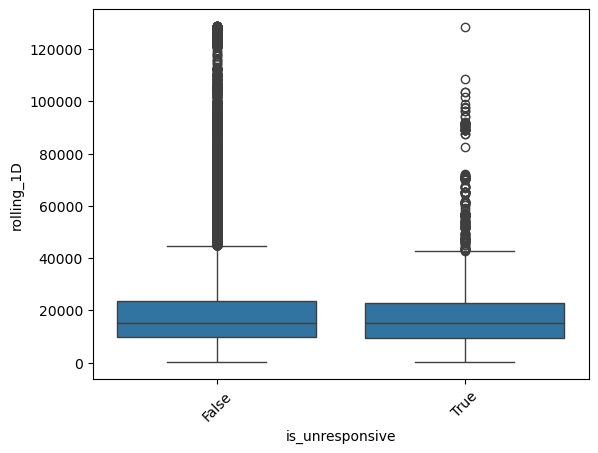

In [123]:
fig, ax = plt.subplots()
sns.boxplot(data=accre_jobs_and_slurm_log, x='is_unresponsive', y='rolling_1D', ax=ax)
#sns.lineplot(data=estimate, x='rolling_6min', y='is_unresponsive', color='purple', ax=ax)
#plt.ylim(0, 200)
plt.xticks(rotation=45);
#ax.xaxis.set_major_locator(ticker.MultipleLocator(5));

## Fit a logistic regression model 

In [58]:
accre_jobs_and_slurm_log["is_unresponsive"].value_counts(normalize=True).reset_index()

,is_unresponsive,proportion
0,False,0.946185
1,True,0.053815


In [59]:
cnt_respv_6m = accre_jobs_and_slurm_log.groupby("is_unresponsive")["rolling_6min"].count().astype('int64').reset_index()
cnt_respv_6m

,is_unresponsive,rolling_6min
0,False,57951
1,True,3296


In [60]:
cnt_respv_1h = accre_jobs_and_slurm_log.groupby("is_unresponsive")["rolling_1hour"].count().astype('int64').reset_index()
cnt_respv_1h

,is_unresponsive,rolling_1hour
0,False,57951
1,True,3296


In [76]:
cnt_respv_1d = accre_jobs_and_slurm_log.groupby("is_unresponsive")["rolling_1D"].count().astype('int64').reset_index()
cnt_respv_1d

,is_unresponsive,rolling_1D
0,False,57951
1,True,3296


In [78]:
print(f"The rolling count of completed jobs within a 6 minute period where accre was responsive is {cnt_respv_6m["rolling_6min"][0]:,} whereas the \n count of completed jobs within a 6 minute period where accre was unresponsive job is {cnt_respv_6m["rolling_6min"][1]:,}")

The rolling count of completed jobs within a 6 minute period where accre was responsive is 57,951 whereas the 
 count of completed jobs within a 6 minute period where accre was unresponsive job is 3,296


In [80]:
#accre_jobs_and_slurm_log.info()

In [82]:
accre_jobs_and_slurm_log["is_unresponsive_int"] = accre_jobs_and_slurm_log["is_unresponsive"].astype(int)
accre_jobs_and_slurm_log.head(2)

,slurm_id,date_time,user,retry,time,returncode,command,sbatch,is_unresponsive,unnamed_job_id,...,NODES,CPUS,PARTITION,EXITCODE,count_of_jobs,minute,rolling_6min,rolling_1D,rolling_1hour,is_unresponsive_int
0,136,2020-10-16 08:34:42.779719,9204,0,5.240251,0,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x...",True,False,7014087,...,1,2,production,0:0,382143,34,49.0,24255.0,581.0,0
1,478,2020-10-16 08:53:15.711346,9204,0,0.142444,0,"['/usr/bin/sbatch', '/tmp/condor_g_scratch.0x...",True,False,6995191,...,1,1,production,0:0,382357,53,85.0,24324.0,436.0,0


In [84]:
is_unresponsive_6m_logreg = smf.logit("is_unresponsive_int ~ rolling_6min",
                          data = accre_jobs_and_slurm_log).fit()

Optimization terminated successfully.
         Current function value: 0.209480
         Iterations 7


In [85]:
is_unresponsive_6m_logreg.params

Intercept      -2.826641
rolling_6min   -0.000532
dtype: float64

In [88]:
is_unresponsive_1h_logreg = smf.logit("is_unresponsive_int ~ rolling_1hour",
                          data = accre_jobs_and_slurm_log).fit()

Optimization terminated successfully.
         Current function value: 0.209510
         Iterations 7


In [125]:
is_unresponsive_1h_logreg.params

Intercept       -2.823659
rolling_1hour   -0.000057
dtype: float64

even if is significant statisticaaly - it points to the opposite - more jobs finishing it is more likely to be responsive

In [92]:
is_unresponsive_1D_logreg = smf.logit("is_unresponsive_int ~ rolling_1D",
                          data = accre_jobs_and_slurm_log).fit()

Optimization terminated successfully.
         Current function value: 0.209598
         Iterations 7


In [128]:
is_unresponsive_1D_logreg.params

Intercept    -2.868086e+00
rolling_1D    6.319892e-08
dtype: float64

the coef is super small - won't chang the prob much - for every additional job run the log odds, increases by the small number of 6.319892e-08

est prob based on median (3rd quartile and the 09th percentile) jobs run in Day, Hour, 6 minute period - output of these models and what does it est for these probs - is_unresponsive_6m_logreg was statistically significant - but was not much probable to be unresponsive is the guess , (if median is 10 in 6 minuites then I'd run 2 5 or 20 30 40 - job run in that 6 minute period)

In [ ]:
#is_unresponsive = 0
#M150 = 150000000

#logreg_prop_ND = m_nom_rev_drama_logreg.params['Intercept'] + m_nom_rev_drama_logreg.params["Revenue"]*M150 + m_nom_rev_drama_logreg.params['Genre_Drama[T.True]']*NonDrama

#print(f'Estimated probability of a movie being nominated when it is not a drama is {logistic(logreg_prop_ND):,.6f}.')

In [109]:
is_unresponsive_1D_logreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     is_unresponsive_int   No. Observations:                61247
Model:                           Logit   Df Residuals:                    61245
Method:                            MLE   Df Model:                            1
Date:                 Sat, 13 Dec 2025   Pseudo R-squ.:               1.130e-07
Time:                         10:32:35   Log-Likelihood:                -12837.
converged:                        True   LL-Null:                       -12837.
Covariance Type:             nonrobust   LLR p-value:                    0.9570
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.8681      0.029   -100.451      0.000      -2.924      -2.812
rolling_1D   6.32e-08   1.17e-06      0.054      0.957   -2.24e-06    2.36e-06
==============================================================================
"""

In [119]:
is_unresponsive_6m_logreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     is_unresponsive_int   No. Observations:                61247
Model:                           Logit   Df Residuals:                    61245
Method:                            MLE   Df Model:                            1
Date:                 Sat, 13 Dec 2025   Pseudo R-squ.:               0.0005631
Time:                         10:34:47   Log-Likelihood:                -12830.
converged:                        True   LL-Null:                       -12837.
Covariance Type:             nonrobust   LLR p-value:                 0.0001434
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -2.8266      0.021   -135.777      0.000      -2.867      -2.786
rolling_6min    -0.0005      0.000     -3.592      0.000      -0.001      -0.000
================================================================================
"""

In [117]:
is_unresponsive_1h_logreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     is_unresponsive_int   No. Observations:                61247
Model:                           Logit   Df Residuals:                    61245
Method:                            MLE   Df Model:                            1
Date:                 Sat, 13 Dec 2025   Pseudo R-squ.:               0.0004206
Time:                         10:34:21   Log-Likelihood:                -12832.
converged:                        True   LL-Null:                       -12837.
Covariance Type:             nonrobust   LLR p-value:                  0.001015
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -2.8237      0.022   -126.711      0.000      -2.867      -2.780
rolling_1hour -5.727e-05   1.82e-05     -3.141      0.002    -9.3e-05   -2.15e-05
=================================================================================
"""

In [100]:
## merge the two log files after distilling them down to unresponsive periods
## rename the slurm id column accordingly
#unresponsive_periods_merged = pd.concat(
#    unresponsive_periods_ce5, 
#    unresponsive_periods_ce6, 
#    on=["Unnamed: 0", "date_time", "user", "retry", "time", "returncode", "command", "sbatch"], 
#    how='outer'
#).rename(
#    columns={"Unnamed: 0": "slurm_id"}
#)
#unresponsive_periods_merged.head(2)

In [ ]:
## Merge_asof completed_jobs with unresponsive_periods_merged
#unresponsive_completed_merged_asof = pd.merge_asof(
#    unresponsive_periods_merged, 
#    completed_jobs, 
#    left_on="date_time", 
#    right_on="END",
#    direction="backward"
#)#.head(50)

In [ ]:
#unresponsive_completed_merged_asof["END"].value_counts()#.min()#.unique()#

In [ ]:
#def build_slurm(filename):
    
    ## read the first of two log files, ce5, into the notebook in chunks
#    chunk = pd.read_csv(f'../data/{filename}',
#                  header=None,
#                  delimiter=' - ',
#                  engine='python',
#                  chunksize=100000)

    ## initialize empty DataFrame: data
#    data = pd.DataFrame()

    ## iterate over each DataFrame chunk
#    for portion in chunk:
        ## rename the columns to words instead of simply numbers
#        named = portion.rename(columns={0: 'date_time', 1: 'user', 2: 'retry', 3: 'time', 4: 'returncode', 5: 'command'})

        ## convert the date_time column to datetime from the format it was originally presented in
        ## assign it back to that column of the ce5_names df
#        named['date_time'] = pd.to_datetime(named['date_time'], format = "mixed")

        ## strip the word user from within the user column and we are left with a number
#        named["user"] = named["user"].str.strip("user")
#        named["user"] = pd.to_numeric(named["user"])

        ## strip the word retry from within the retry column and we are left with a number
#        named["retry"] = named["retry"].str.strip("retry")
#        named["retry"] = pd.to_numeric(named["retry"])

        ## strip the word time from within the time column and we are left with a number
#        named["time"] = named["time"].str.strip("time")
#        named["time"] = pd.to_numeric(named["time"])
    
        ## strip the word returncode from within the returncode column and we are left with a number
#        named["returncode"] = named["returncode"].str.strip("returncode")
#        named["returncode"] = pd.to_numeric(named["returncode"])

        ## strip the word command from within the command column
#        named["command"] = named["command"].str.strip("command")

        ## locate rows which contain sbatch 
#        named["sbatch"] = named["command"].str.contains("/usr/bin/sbatch")
        ## save rows where the command column contains sbatch to a new df, named_sbatch
#        named_sbatch = named[named["sbatch"] == True]

        ## locate and save rows where the user column contains 9204 to a new df, named_sbatch_user
#        named_sbatch_user = named_sbatch[named_sbatch["user"] == 9204]

        ## locate and save rows where the returncode column contains 1 to a new df, named_sbatch_user_returncode
        ## locate and save rows where the returncode column contains 1 to a new df, unresponsive_periods
#        named_sbatch_user["is_unresponsive"] = (named_sbatch_user["returncode"] == 1) & (named_sbatch_user["time"] > 15)

        # Concatenate DataFrame chunk to the end of data: data
#        data = pd.concat([data, named_sbatch_user])
#    data.to_csv('../data/ce6_slurm_isresponsive.csv')#('../data/ce5_slurm_unresponsive_periods.csv')
    
#    return data

In [ ]:
#unresponsive_completed_merged_asof.drop_duplicates(subset="date_time", keep="last")

In [ ]:
#unresponsive_compelted_merged_asof[unresponsive_compelted_merged_asof["END"] == "2020-10-18 06:13:19"]#["command"].value_counts()

In [ ]:
#unresponsive_compelted_merged_asof

In [ ]:
# check that datetime conversion went through
#jobs_replace_unknown.info()

In [ ]:
# inspect head(2) of the jobsjobs_replace df
#completed_exit#.head(2)

In [ ]:
## Jobs where memory was requested per node.
#completed_exit[completed_exit['REQMEM'].str[-2:] == 'Mn'].head(2)

In [ ]:
## Jobs where memory was requested per core.
#completed_exit[completed_exit['REQMEM'].str[-2:] == 'Mc'].head(2)

In [ ]:
## check to see how many unique values are in the partition column
## and their counts
## The "debug" and "sam" partitions are test jobs that are expected to be short from the partitions column in jobs
#completed_exit["PARTITION"].value_counts()

In [ ]:
#def build_slurm(filename):
    
    ## read the first of two log files, ce5, into the notebook in chunks
#    chunk = pd.read_csv(f'../data/{filename}',
#                  header=None,
#                  delimiter=' - ',
#                  engine='python',
#                  chunksize=100000)

    ## initialize empty DataFrame: data
#    data = pd.DataFrame()

    ## iterate over each DataFrame chunk
#    for portion in chunk:
        ## rename the columns to words instead of simply numbers
#        named = portion.rename(columns={0: 'date_time', 1: 'user', 2: 'retry', 3: 'time', 4: 'returncode', 5: 'command'})

        ## convert the date_time column to datetime from the format it was originally presented in
        ## assign it back to that column of the ce5_names df
#        named['date_time'] = pd.to_datetime(named['date_time'], format = "mixed")

        ## strip the word user from within the user column and we are left with a number
#        named["user"] = named["user"].str.strip("user")
#        named["user"] = pd.to_numeric(named["user"])

        ## strip the word retry from within the retry column and we are left with a number
#        named["retry"] = named["retry"].str.strip("retry")
#        named["retry"] = pd.to_numeric(named["retry"])

        ## strip the word time from within the time column and we are left with a number
#        named["time"] = named["time"].str.strip("time")
#        named["time"] = pd.to_numeric(named["time"])
    
        ## strip the word returncode from within the returncode column and we are left with a number
#        named["returncode"] = named["returncode"].str.strip("returncode")
#        named["returncode"] = pd.to_numeric(named["returncode"])

        ## strip the word command from within the command column
#        named["command"] = named["command"].str.strip("command")

        ## locate rows which contain sbatch 
#        named["sbatch"] = named["command"].str.contains("/usr/bin/sbatch")
        ## save rows where the command column contains sbatch to a new df, named_sbatch
#        named_sbatch = named[named["sbatch"] == True]

        ## locate and save rows where the user column contains 9204 to a new df, named_sbatch_user
#        named_sbatch_user = named_sbatch[named_sbatch["user"] == 9204]

        ## locate and save rows where the returncode column contains 1 to a new df, named_sbatch_user_returncode
#        named_sbatch_user_returncode = named_sbatch_user[named_sbatch_user["returncode"] == 1]

        ## locate and save rows where the returncode column contains 1 to a new df, unresponsive_periods
#        unresponsive_periods = named_sbatch_user_returncode[named_sbatch_user_returncode["time"] > 15]

        # Concatenate DataFrame chunk to the end of data: data
#        data = pd.concat([data, unresponsive_periods])
#    data.to_csv('../data/ce6_slurm_unresponsive_periods.csv')#('../data/ce5_slurm_unresponsive_periods.csv')
    
#    return data

In [ ]:
#

In [ ]:
#slurm_isresponsive_6 = build_slurm(filename)

In [ ]:
#slurm_isresponsive_6.head(2)

In [ ]:
#slurm_isresponsive_5.head(2)

In [ ]:
## assign the END column rows which have a value of unknown to a new df
#jobs_unknown = jobs[jobs["END"]=="Unknown"]

In [ ]:
#jobs

In [ ]:
#jobs_replace[0:3]

In [ ]:
#jobs_replace[jobs_replace['JOBID'].str.contains('_')]

### Phase 2: Clean and Transform the Data

#### Objectives:
Extract job completions from fullsample.csv. <br>
Parse CE5 and CE6 logs to identify unresponsive events. <br>
Create analysis-ready features (time windows, completion counts, unresponsiveness indicators). <br>
Optionally include other features (currently running jobs or resource usage, time-of-day).

#### Notebook Sections:
Code: Filtering and transforming datasets <br>
Markdown: Document preprocessing steps and reasoning <br>
Code: Combine datasets into a single dataset suitable for analysis

### 3. Feature engineering  FINAL Deliverables - rolling time window

### Phase 3: Analyze and Visualize

#### Objectives:
Explore the relationship between job completions and unresponsiveness. <br>
Create visualizations and basic summary statistics

#### Notebook Sections:
Code: Time-series plots, scatterplots, boxplots, summary statistics. <br>
Markdown: Interpret the visualizations and describe patters. <br>
Code: Fit a simple logistic regression to test the hypothesis. <br>
Markdown: Summarize the results and draw conclusions from the model. <br>
Optional: Explore additional factors (eg. day of week).

### Phase 4: Interpret and Conclude

#### Objectives:
Answer the main question: Does the data support the hypothesis that the slurm scheduler is more likely to be unresponsive during bursts of job completions? <br>
Summarize findings and limitations.

#### Notebook Sections:
Markdown: Summarize evidence for or against the hypothesis. <br>
Markdown: Provide a clear conclusions.

### Final Deliverable: A single Jupyter notebook that includes:

1. Introduction & dataset overview
2. Data exploration & cleaning
3. Feature engineering
4. Analysis & visualizations
5. Interpretation & Conclusion